# Demo how to make predictions with OSnet, using all built-in default variables

|<img src="https://github.com/euroargodev/OSnet-GulfStream/raw/main/docs/_static/osnet_landscape.png" width="300px"/>|
|:---------:|
|``OSnet`` is a python library to make T/S/MLD predictions in the Gulf Stream Extension using Neural Network|

<b>Warning: These predictions are made using climatological input fields for SST and SLA !</b>

This notebook requires cartopy, cmocean and argopy

In [1]:
import os, sys

# Assume OSnet is one parent folder away from this notebook:
sys.path.insert(0, os.path.split(os.path.abspath(os.path.curdir))[0])  
import osnet
from osnet.options import OPTIONS
osnet.disclaimer()

In [2]:
import pandas as pd
import xarray as xr
import numpy as np
import argopy

# For plots
xr.set_options(display_style="text", display_expand_attrs=False);
import matplotlib.pyplot as plt
import colorcet as cc
import cmocean
import time
import cartopy.crs as ccrs

# Dictionnary of colormaps for variables
cmapd = {'BATHY': cmocean.cm.topo, 
      'MDT': cmocean.cm.delta, 
      'SST': cmocean.cm.thermal, 
      'SLA': cmocean.cm.balance, 
      'UGOSA': cmocean.cm.balance, 
      'VGOSA': cmocean.cm.balance, 
      'UGOS': cmocean.cm.balance,
      'VGOS': cmocean.cm.balance,
      'temp': cmocean.cm.thermal, 
      'temp_adj': cmocean.cm.thermal, 
      'temp_std': cmocean.cm.amp, 
      'psal': cmocean.cm.haline, 
      'psal_adj': cmocean.cm.haline, 
      'psal_std': cmocean.cm.amp, 
      'sig': cmocean.cm.dense, 
      'sig_adj': cmocean.cm.dense, 
      'sig_std': cmocean.cm.amp, 
      'mld': cc.cm["rainbow"]
     }

def add_map(this_ax):
    """
        >>> fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6), dpi=90, subplot_kw={"projection": ccrs.PlateCarree()})
        >>> add_map(ax)
    """
    this_ax.add_feature(argopy.plotters.land_feature, edgecolor="black")
    this_ax.set_xlim(osnet.utilities.conv_lon(OPTIONS['domain'][0])-1, osnet.utilities.conv_lon(OPTIONS['domain'][1])+1)
    this_ax.set_ylim(OPTIONS['domain'][2]-1, OPTIONS['domain'][3]+1)
    argopy.plotters.latlongrid(this_ax, dx="auto", dy="auto", fontsize="auto");
    return this_ax

# Load OSnet model

In [3]:
%%time
m = osnet.load('Gulf-Stream')
m

/Users/gmaze/anaconda/envs/OSnet/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
2022-03-01 12:50:32.306348: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


CPU times: user 3.81 s, sys: 156 ms, total: 3.97 s
Wall time: 4 s


<osnet.GulfStream>
Reference: Pauthenet et al, 2022 (http://dx.doi.org/...)
Models: 15 instance(s) in the ensemble
MLD adjusted: True

# Make a collection of input grid to make prediction for

In [4]:
input_list = {}

## 1D station

In [5]:
ds_in = xr.Dataset({}, coords={
    'lon': (['lon'], np.array(-54)[np.newaxis]),
    'lat': (['lat'], np.array(35)[np.newaxis]),
    'time': np.array(np.datetime64('2005-11-30'))[np.newaxis]
})
input_list['station'] = ds_in

## 2D local timeseries

In [6]:
x = np.array(360-54)[np.newaxis]
y = np.array(35)[np.newaxis]
t = pd.date_range("1998-09-01", "2000-08-31", freq='M')

ds_in = xr.Dataset({}, coords={
    'lon': (['lon'], x),
    'lat': (['lat'], y),
    'time': t
})
input_list['local_timeseries'] = ds_in

## 2D horizonal snapshot

In [7]:
# OPTIONS['domain'] = [360-80, 360-30, 23, 50]
# OPTIONS['domain'] = [360-80, 360-30, 23, 50]

x = np.arange(OPTIONS['domain'][0]-1, OPTIONS['domain'][1]+1, 1/2)
y = np.arange(OPTIONS['domain'][2]-1, OPTIONS['domain'][3]+1, 1/2)
t = np.array(np.datetime64('2005-11-30'))[np.newaxis]

ds_in = xr.Dataset({}, coords={
    'lon': (['lon'], x),
    'lat': (['lat'], y),
    'time': t
})
input_list['snapshot'] = ds_in

## 2D meridional transect

In [8]:
x = np.array(-54)[np.newaxis]
y = np.arange(OPTIONS['domain'][2]-1, OPTIONS['domain'][3]+1, 1/2)
t = np.array(np.datetime64('2009-02-12'))[np.newaxis]

ds_in = xr.Dataset({}, coords={
    'lon': (['lon'], x),
    'lat': (['lat'], y),
    'time': t
})
input_list['meridional_transect'] = ds_in

## 2D zonal transect

In [9]:
x = np.arange(OPTIONS['domain'][0]-1, OPTIONS['domain'][1]+1, 1/2)
y = np.array(36.)[np.newaxis]
t = np.array(np.datetime64('2005-02-12'))[np.newaxis]

ds_in = xr.Dataset({}, coords={
    'lon': (['lon'], x),
    'lat': (['lat'], y),
    'time': t
})
input_list['zonal_transect'] = ds_in

## 2D Along Argo float trajectory

In [10]:
from argopy import DataFetcher as argo

# ds_float = argo(cache=True).float(4902503).data.argo.point2profile()
ds_float = argo(cache=True).float(3901602).data.argo.point2profile()
# ds_float = argo(cache=True).float(4902321).data.argo.point2profile()
# ds_float = argo(cache=True).float(4902324).data.argo.point2profile()

ds_in = xr.Dataset({}, coords={
    'sampling': (['sampling'], ds_float['N_PROF'].data),
    'lon': (['sampling'], ds_float['LONGITUDE'].data),
    'lat': (['sampling'], ds_float['LATITUDE'].data),
    'time': (['sampling'], ds_float['TIME'].data),
    'CYCLE_NUMBER': (['sampling'], ds_float['CYCLE_NUMBER'].data),  # Just for easy plotting of output
})
input_list['argo_float'] = ds_in

# Make predictions for all inputs

In [11]:
output_list = {}
for key, ds_in in input_list.items():
    print("Make predictions for: %s" % key)
    start = time.time()
    output_list[key] = m.predict(ds_in)
    Nsample = output_list[key].attrs['OSnet-Nsample']
    dt = time.time() - start
    print("\tdone in %0.3f secs (%0.3f ms/N, with N=%i)" % (dt, dt/Nsample*1e3, Nsample))
    # # ds_out = m.predict(ds_in, inplace=False)
    # # ds_out = m.predict(ds_in, keep_added=True)
    # # ds_out = m.predict(ds_in, keep_added=True, adjust_mld=False)
    # # ds_out = m.predict(ds_in, scaled=False)

Make predictions for: station
	done in 2.296 secs (2296.133 ms/N, with N=1)
Make predictions for: local_timeseries
	done in 1.391 secs (57.952 ms/N, with N=24)
Make predictions for: snapshot
	done in 3.350 secs (0.734 ms/N, with N=4566)
Make predictions for: meridional_transect
	done in 1.511 secs (32.155 ms/N, with N=47)
Make predictions for: zonal_transect
	done in 1.547 secs (17.001 ms/N, with N=91)
Make predictions for: argo_float
	done in 1.536 secs (8.394 ms/N, with N=183)


# Figures for output

## 1D station

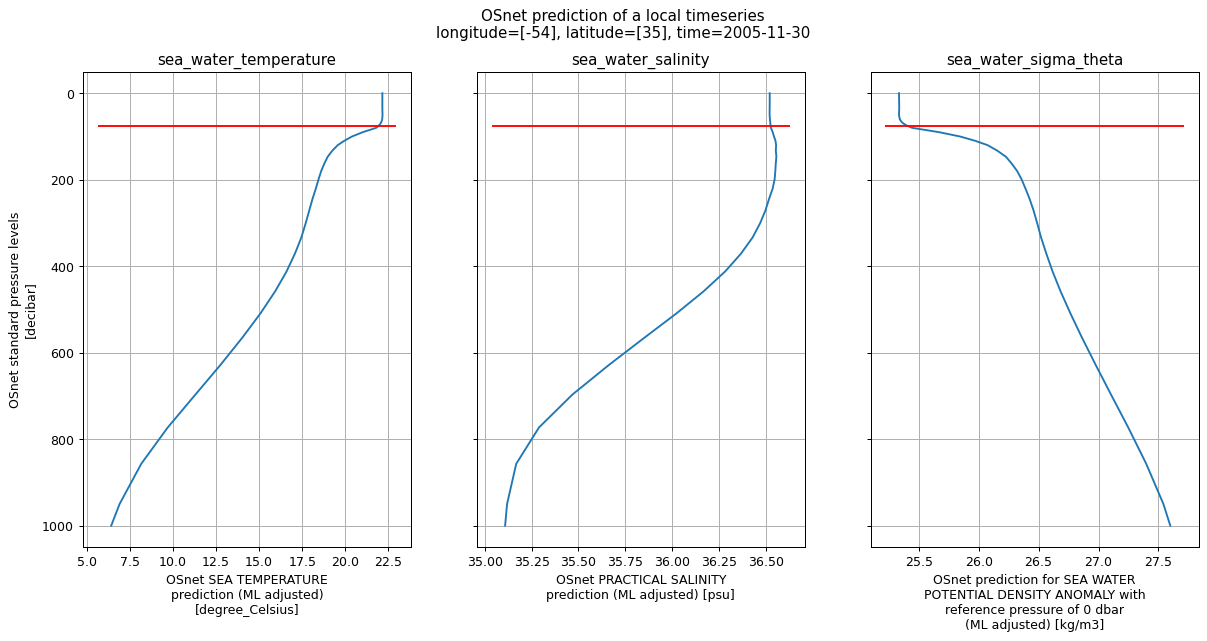

In [12]:
ds_out = output_list['station']

if 'temp_adj' in ds_out:
    fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(16,7), dpi=90, sharex=False, sharey=True)
    ax = np.array(ax).flatten()
    vlist = ['temp_adj', 'psal_adj', 'sig_adj']
else:
    fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(20,7), dpi=90, sharex=False, sharey=True)
    ax = np.array(ax).flatten()
    vlist = ['temp', 'psal']
    
for i, v in enumerate(vlist):
    this = ds_out[v].isel(lat=0, lon=0, time=0)
    this.plot(y='PRES_INTERPOLATED', ax=ax[i], yincrease=False)
    ax[i].hlines(ds_out['mld'].isel(lat=0, lon=0, time=0), ax[i].get_xlim()[0], ax[i].get_xlim()[-1], 'r')
    ax[i].set_ylabel('')
    ax[i].set_title("%s" % this.attrs['standard_name'])
    ax[i].grid()
ax[0].set_ylabel("%s\n[%s]" % (ds_out['PRES_INTERPOLATED'].attrs['long_name'], ds_out['PRES_INTERPOLATED'].attrs['units']))

fig.suptitle('OSnet prediction of a local timeseries\nlongitude=%s, latitude=%s, time=%s' % (ds_out['lon'].data, 
                                                                                             ds_out['lat'].data, 
                                                                                             pd.to_datetime(ds_out['time'].values[0]).strftime('%Y-%m-%d')));

## 2D local timeseries

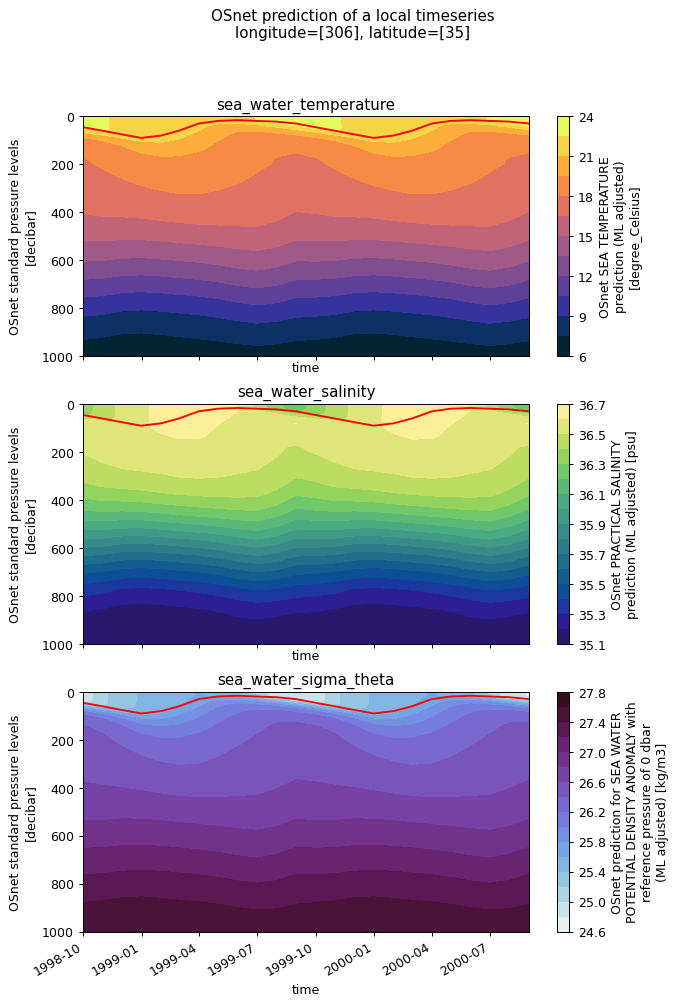

In [13]:
ds_out = output_list['local_timeseries']

if 'temp_adj' in ds_out:
    fig, ax = plt.subplots(ncols=1, nrows=3, figsize=(8,12), dpi=90, sharex=True, sharey=True)
    ax = np.array(ax).flatten()
    vlist = ['temp_adj', 'psal_adj', 'sig_adj']
else:
    fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(20,7), dpi=90, sharex=True, sharey=True)
    ax = np.array(ax).flatten()
    vlist = ['temp', 'psal']
    
for i, v in enumerate(vlist):
    this = ds_out[v].isel(lat=0, lon=0)
    this.plot.contourf(x='time', ax=ax[i], levels=17, cmap=cmapd[v], yincrease=False)
    ax[i].plot(ds_out['time'], ds_out['mld'].isel(lat=0, lon=0), 'r')
    ax[i].set_title("%s" % this.attrs['standard_name'])
fig.suptitle('OSnet prediction of a local timeseries\nlongitude=%s, latitude=%s' % (ds_out['lon'].data, ds_out['lat'].data));

## 2D horizontal snapshot

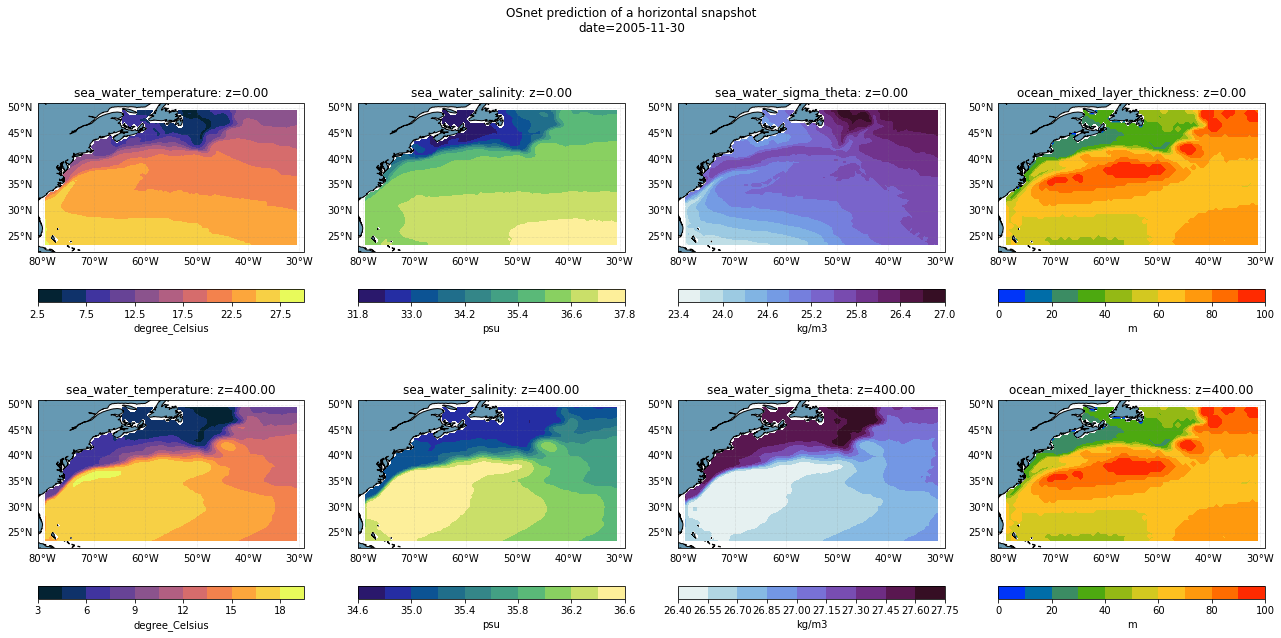

In [14]:
ds_out = output_list['snapshot']

if 'temp_adj' in ds_out:
    fig, ax = plt.subplots(ncols=4, nrows=2, figsize=(22,10), sharex=True, sharey=True, subplot_kw={"projection": ccrs.PlateCarree()})
    ax = np.array(ax).flatten()
    vlist = ['temp_adj', 'psal_adj', 'sig_adj', 'mld']
else:
    fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(20,10), sharex=True, sharey=True, subplot_kw={"projection": ccrs.PlateCarree()})
    ax = np.array(ax).flatten()
    vlist = ['temp', 'psal', 'mld']
    
for i, v in enumerate([(z,v) for z in [0, 400] for v in vlist]):
    z, vname = v[0], v[1]
    if 'PRES_INTERPOLATED' in ds_out[vname].dims:
        this = ds_out[vname].isel(time=0).sel(PRES_INTERPOLATED=z, method='nearest')
    else:
        this = ds_out[vname].isel(time=0)

    add_map(ax[i])
    cs = this.plot.contourf(x='lon', ax=ax[i], levels=12, cmap=cmapd[vname], cbar_kwargs={'orientation':'horizontal', 'label':this.attrs['units']})
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
    ax[i].set_title("%s: z=%0.2f" % (this.attrs['standard_name'], z))
fig.suptitle('OSnet prediction of a horizontal snapshot\ndate=%s' % (pd.to_datetime(ds_out['time'].values[0]).strftime('%Y-%m-%d')));

## 2D meridional transect

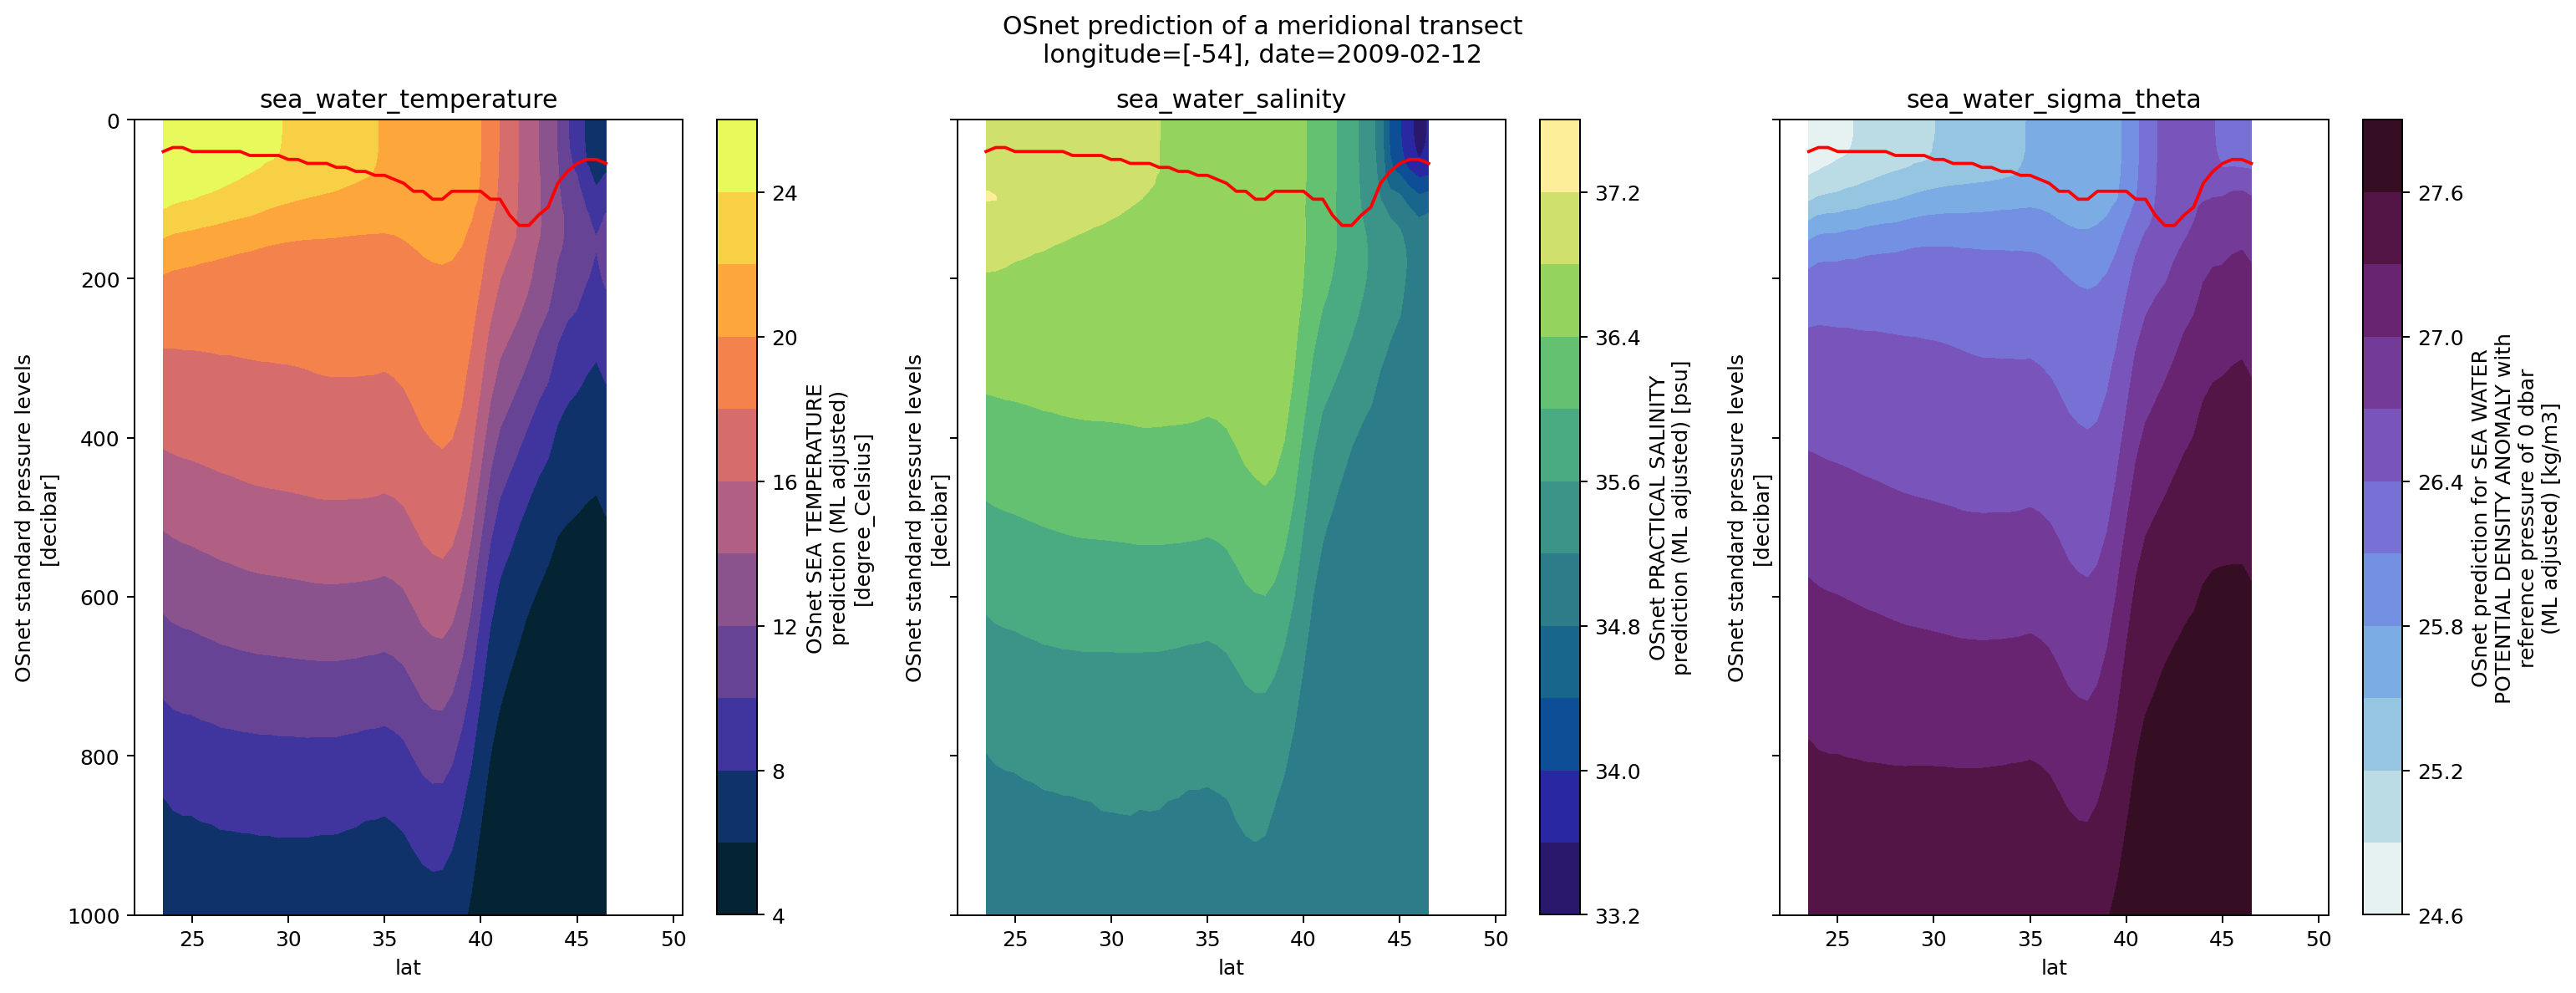

In [15]:
ds_out = output_list['meridional_transect']

if 'temp_adj' in ds_out:
    fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(20,7), dpi=180, sharex=True, sharey=True)
    ax = np.array(ax).flatten()
    vlist = ['temp_adj', 'psal_adj', 'sig_adj']
else:
    fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(20,7), dpi=180, sharex=True, sharey=True)
    ax = np.array(ax).flatten()
    vlist = ['temp', 'psal']
    
for i, v in enumerate(vlist):
    this = ds_out[v].isel(time=0, lon=0)
    this.plot.contourf(x='lat', ax=ax[i], levels=12, cmap=cmapd[v], yincrease=False)
    ax[i].plot(ds_out['lat'], ds_out['mld'].isel(time=0, lon=0), 'r')
#     ax[i].set_xlabel('')
#     ax[i].set_ylabel('')
    ax[i].set_title("%s" % this.attrs['standard_name'])
fig.suptitle('OSnet prediction of a meridional transect\nlongitude=%s, date=%s' % (ds_out['lon'].data, pd.to_datetime(ds_out['time'].values[0]).strftime('%Y-%m-%d')));

## 2D zonal transect

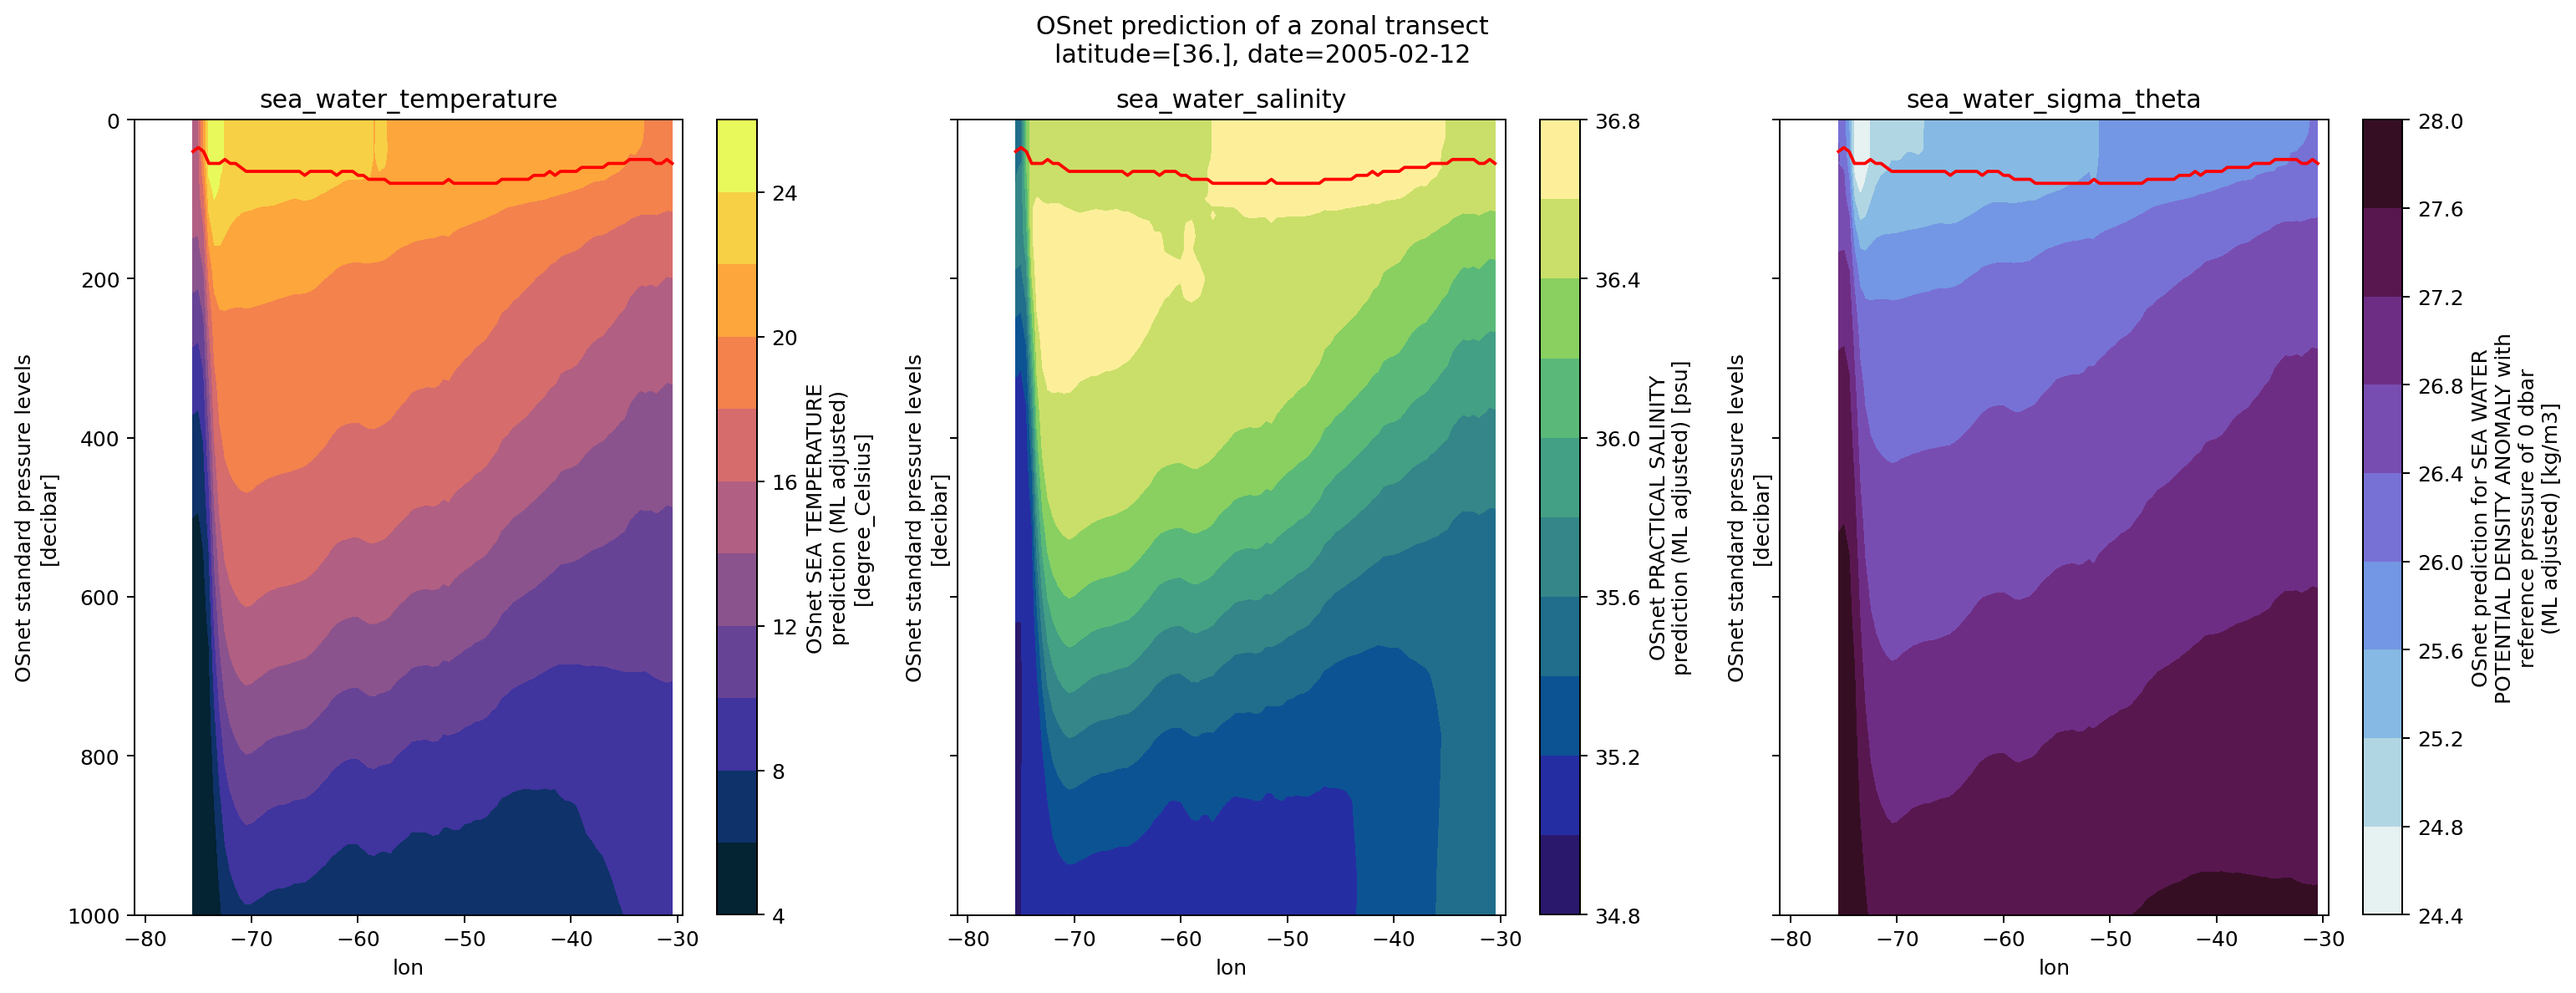

In [16]:
ds_out = output_list['zonal_transect']

if 'temp_adj' in ds_out:
    fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(20,7), dpi=180, sharex=True, sharey=True)
    ax = np.array(ax).flatten()
    vlist = ['temp_adj', 'psal_adj', 'sig_adj']
else:
    fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(20,7), dpi=180, sharex=True, sharey=True)
    ax = np.array(ax).flatten()
    vlist = ['temp', 'psal']
    
for i, v in enumerate(vlist):
    this = ds_out[v].isel(time=0, lat=0)
    this.plot.contourf(x='lon', ax=ax[i], levels=12, cmap=cmapd[v], yincrease=False)
    ax[i].plot(ds_out['lon'], ds_out['mld'].isel(time=0, lat=0), 'r')
    ax[i].set_title("%s" % this.attrs['standard_name'])
fig.suptitle('OSnet prediction of a zonal transect\nlatitude=%s, date=%s' % (ds_out['lat'].data, pd.to_datetime(ds_out['time'].values[0]).strftime('%Y-%m-%d')));    

## 2D along Argo float trajectory

Text(0.5, 0.98, 'OSnet prediction along profiles of an Argo float\nWMO=3901602')

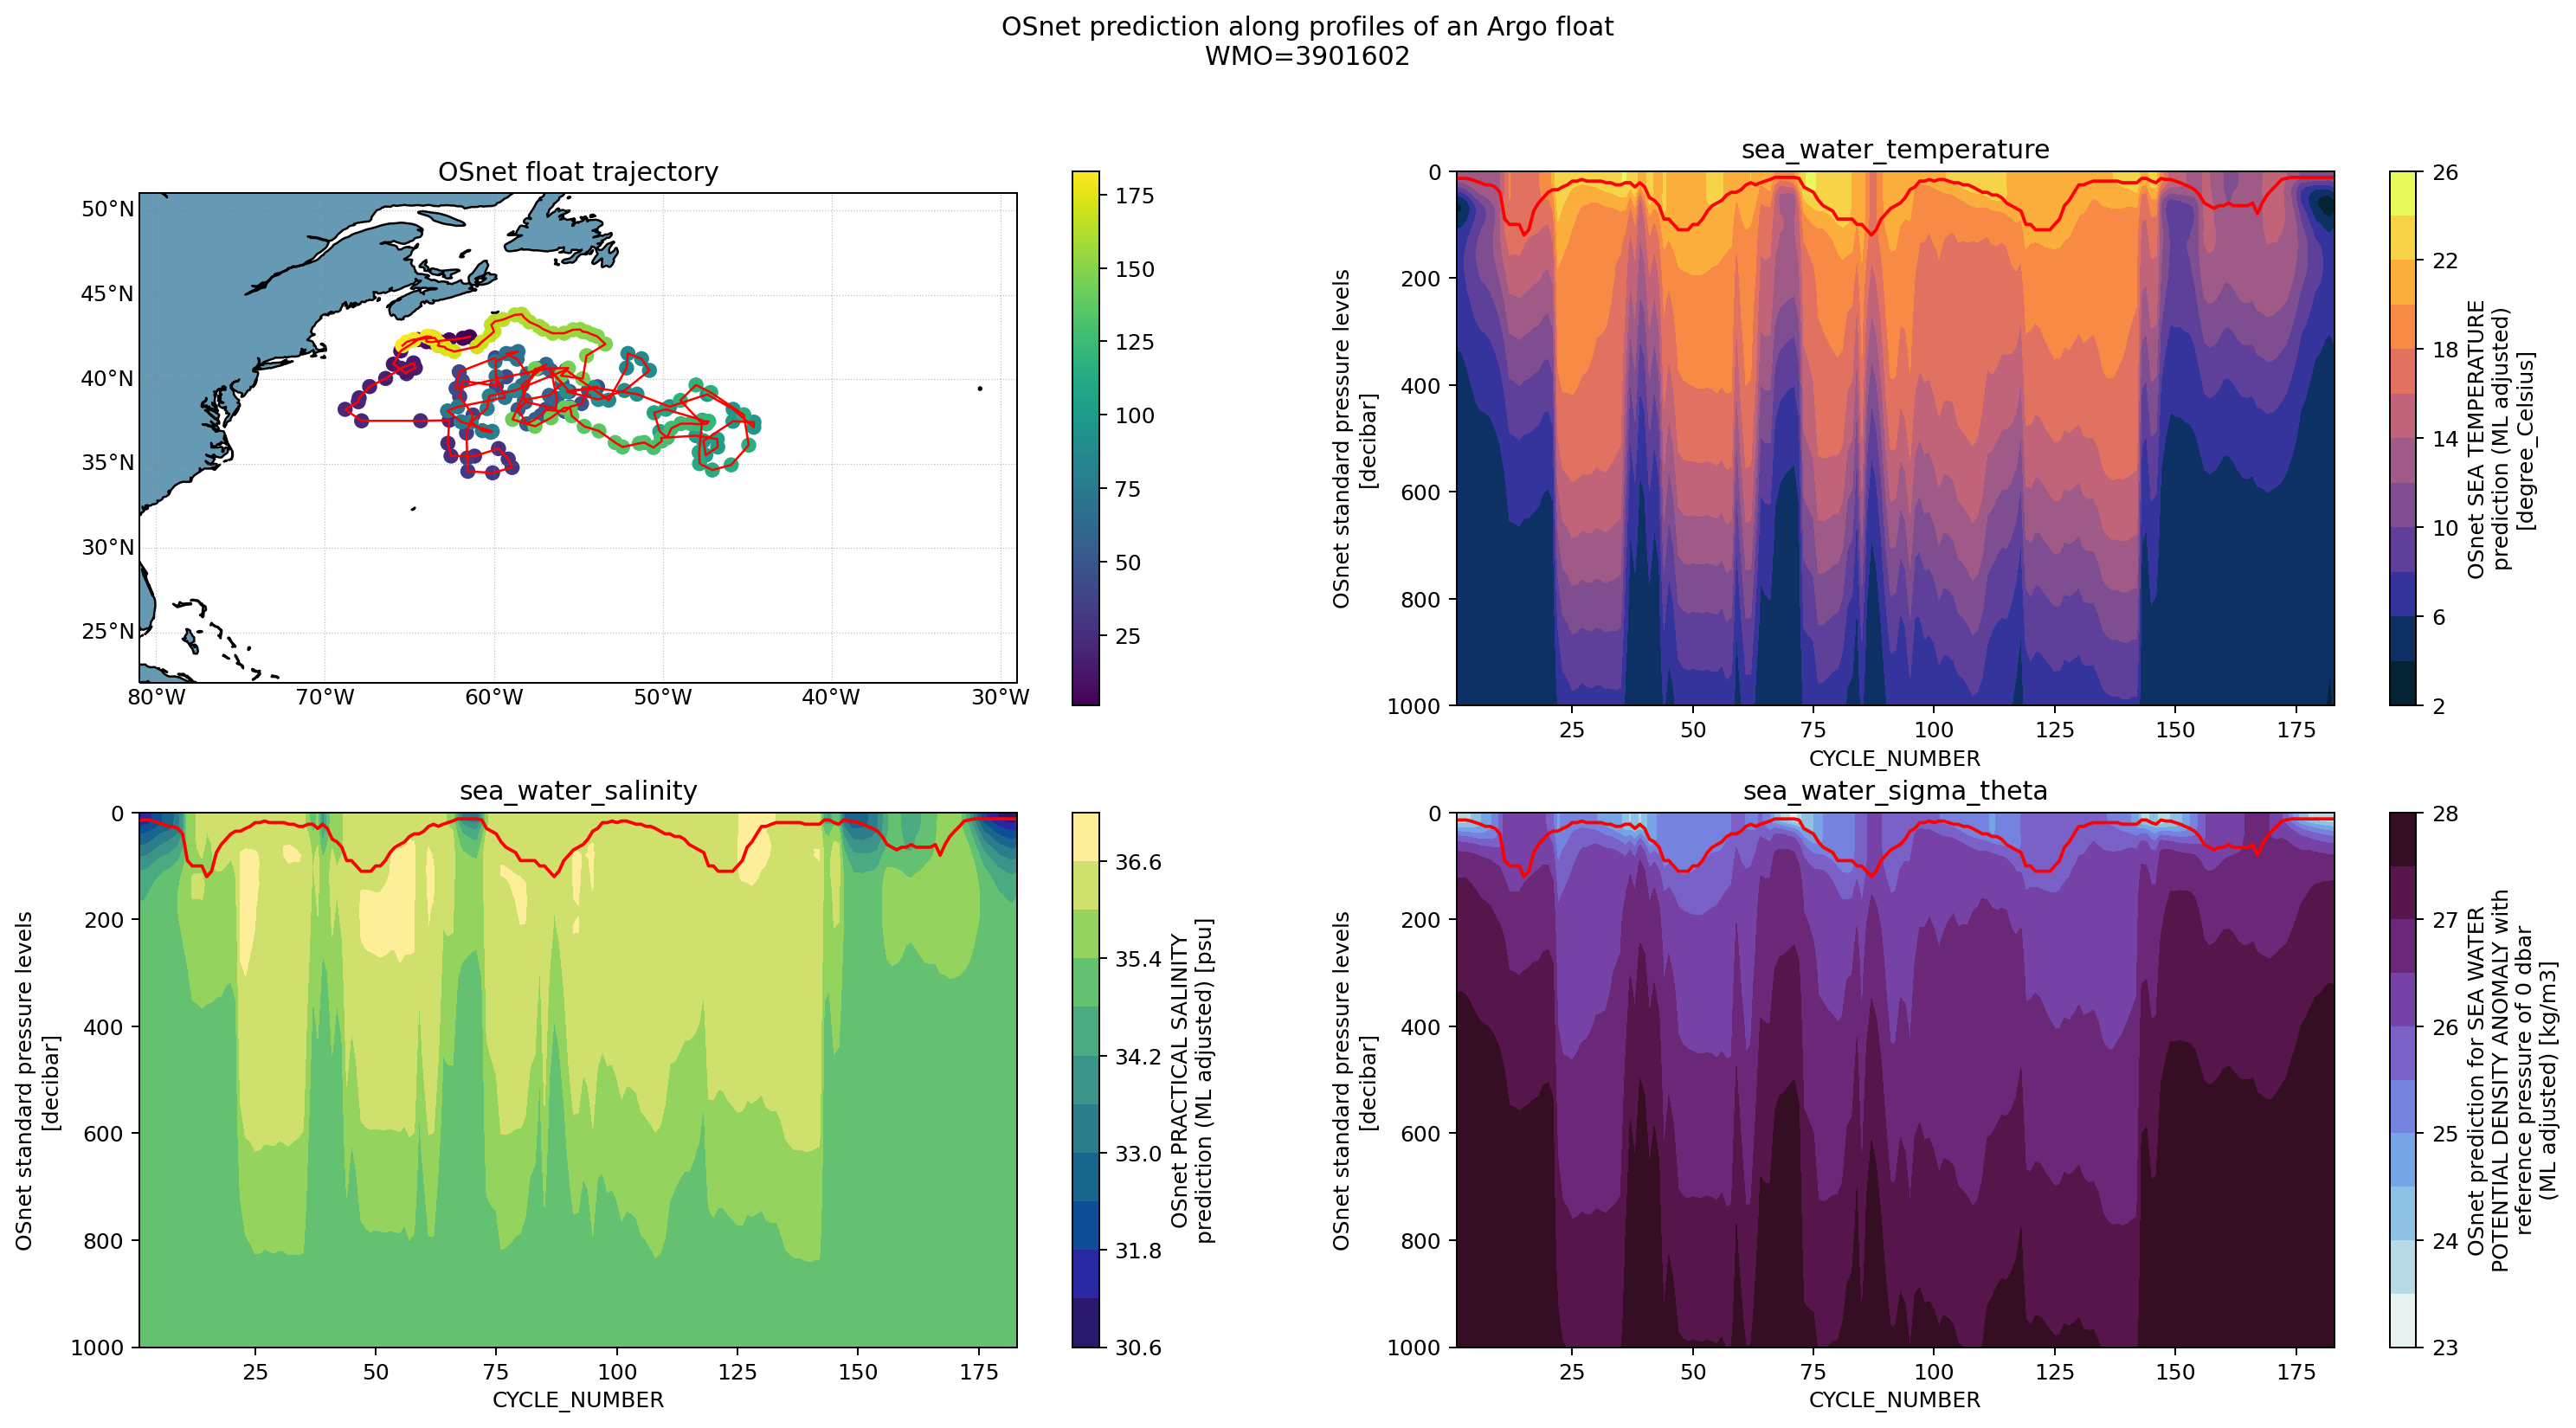

In [17]:
ds_out = output_list['argo_float']

fig = plt.figure(figsize=(20,10), dpi=180)
ax = []
ax.append(fig.add_subplot(221, projection=ccrs.PlateCarree()))
ax.append(fig.add_subplot(222))
ax.append(fig.add_subplot(223))
ax.append(fig.add_subplot(224))

add_map(ax[0])
ax[0].plot(ds_out['lon'], ds_out['lat'], 'r', linewidth=1)
sc = ax[0].scatter(ds_out['lon'], ds_out['lat'], c=ds_out['CYCLE_NUMBER'])
plt.colorbar(sc, ax=ax[0])
ax[0].set_title('OSnet float trajectory')

vlist = ['temp_adj', 'psal_adj', 'sig_adj']
for i, v in enumerate(vlist):
    this = ds_out[v]#.isel(time=0, lat=0)
    this.plot.contourf(x='CYCLE_NUMBER', ax=ax[i+1], levels=12, cmap=cmapd[v], yincrease=False)
    ax[i+1].plot(ds_out['CYCLE_NUMBER'], ds_out['mld'], 'r')
    ax[i+1].set_title("%s" % this.attrs['standard_name'])
fig.suptitle('OSnet prediction along profiles of an Argo float\nWMO=%i' % 
             (np.unique(ds_float['PLATFORM_NUMBER'])[0]))

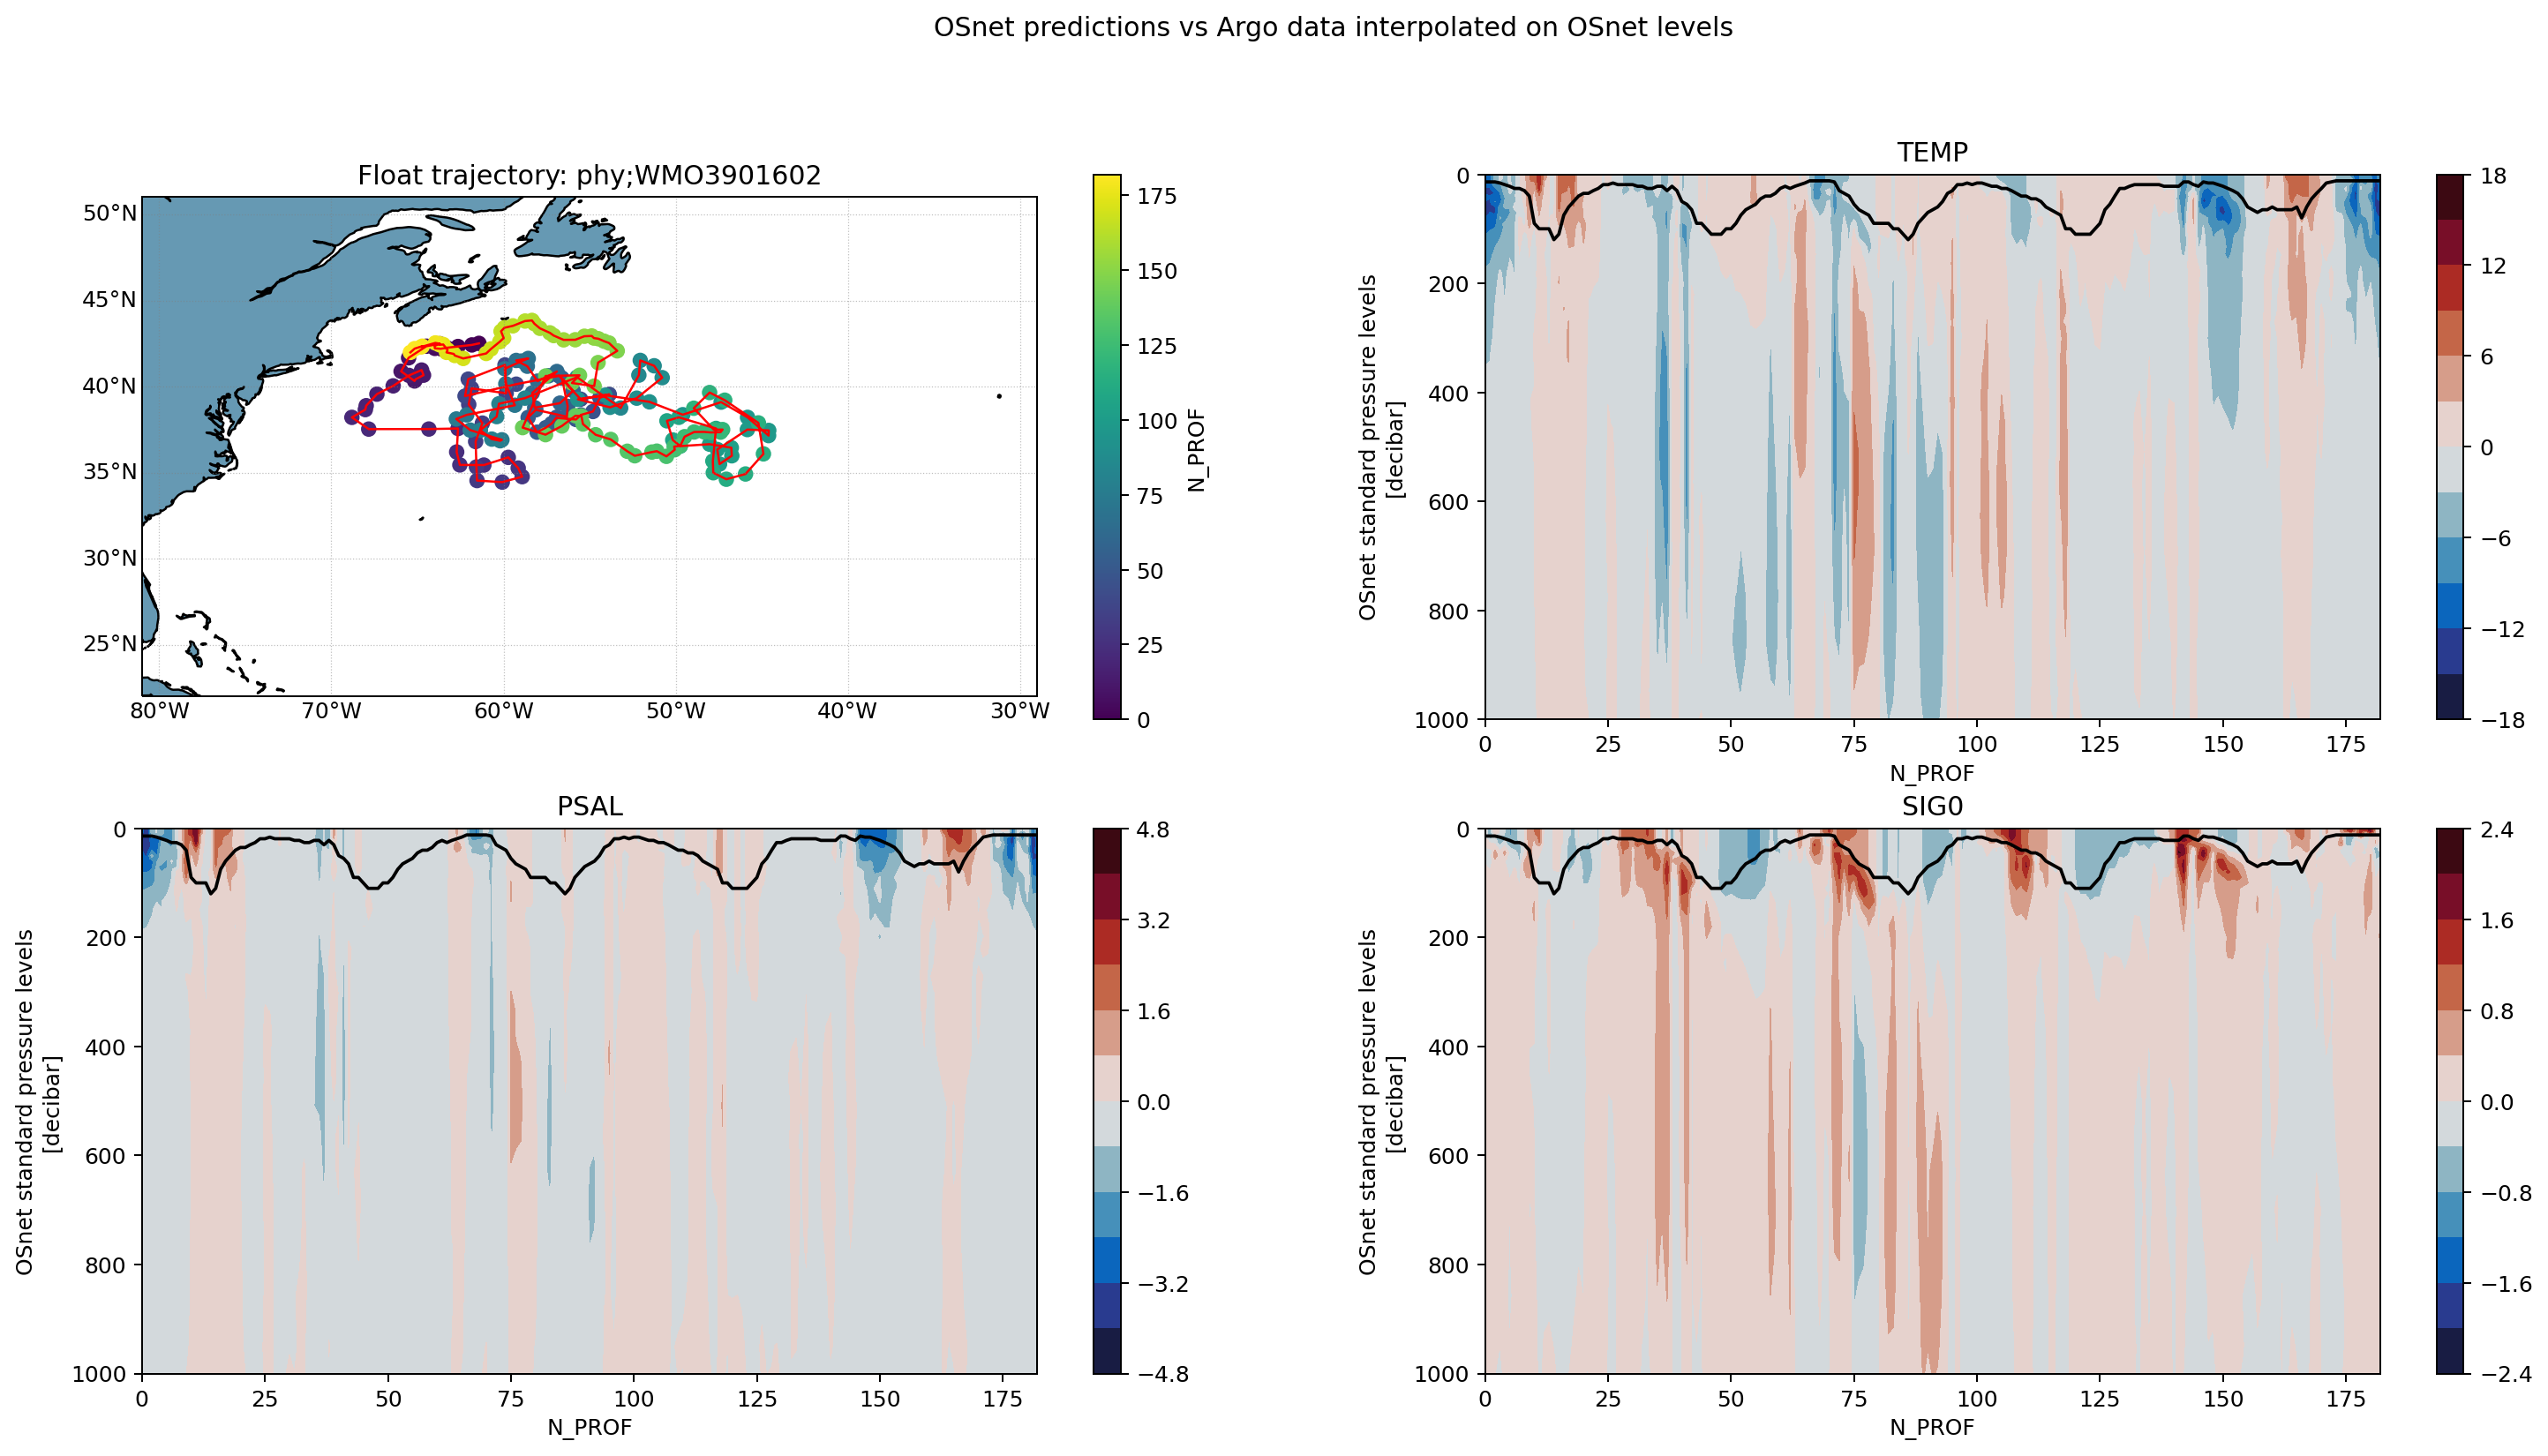

In [18]:
# Interpolate Argo data on OSnet standard depth levels:
ds_float_i = ds_float.argo.teos10(['SIG0'], inplace=True).argo.interp_std_levels(m.SDL)

# Plot it:
fig = plt.figure(figsize=(20,10), dpi=180)
ax = []
ax.append(fig.add_subplot(221, projection=ccrs.PlateCarree()))
ax.append(fig.add_subplot(222))
ax.append(fig.add_subplot(223))
ax.append(fig.add_subplot(224))

add_map(ax[0])
ax[0].plot(ds_float['LONGITUDE'], ds_float['LATITUDE'], 'r', linewidth=1)
sc = ax[0].scatter(ds_float['LONGITUDE'], ds_float['LATITUDE'], c=ds_float['N_PROF'])
plt.colorbar(sc, ax=ax[0], label='N_PROF')
ax[0].set_title('Float trajectory: %s' % ds_float.attrs['Fetched_constraints']);

vlist = ['TEMP', 'PSAL', 'SIG0']    
for i, v in enumerate(vlist):
    # this = ds_float_i[v]
    this = ds_out.rename({'sampling':'N_PROF'})[v.lower().replace('0','')+'_adj']-ds_float_i[v]    
    this.plot.contourf(x='N_PROF', ax=ax[i+1], levels=13, cmap=cmocean.cm.balance, yincrease=False)
    ax[i+1].plot(ds_out.rename({'sampling':'N_PROF'})['N_PROF'], ds_out['mld'], 'k')
    ax[i+1].set_title("%s" % v)
fig.suptitle('OSnet predictions vs Argo data interpolated on OSnet levels');

***

In [19]:
osnet.disclaimer()
osnet.show_versions()


INSTALLED VERSIONS
------------------
commit: None
python: 3.8.12 | packaged by conda-forge | (default, Jan 30 2022, 23:33:09) 
[Clang 11.1.0 ]
python-bits: 64
OS: Darwin
OS-release: 18.7.0
machine: x86_64
processor: i386
byteorder: little
LC_ALL: en_US.UTF-8
LANG: en_US.UTF-8
LOCALE: en_US.UTF-8
libhdf5: 1.10.6
libnetcdf: 4.8.1

osnet: 999
tensorflow: 2.7.0
keras: 2.7.0
joblib: 1.1.0
numba: 0.53.1
dask: 2022.01.0
numpy: 1.22.0
scipy: 1.7.3
pandas: 1.3.5
xarray: 0.20.2
sklearn: 1.0.2
matplotlib: 3.5.1
gsw: 3.4.0
seaborn: 0.11.2
IPython: 8.0.0
netCDF4: 1.5.7
packaging: 21.3
pip: 21.3.1
